In [1]:
from envs.asu.env_copy import ASUEnv, make_asu_env
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io as sio

In [2]:
usim = sio.loadmat('/Users/joseph/Downloads/usim.mat')['usim']
ysim = sio.loadmat('/Users/joseph/Downloads/ysim.mat')['ysim']
dusim = usim[1:, :] - usim[:-1, :]
dusim /= (np.array([6, 4e-3, 1e-2, 2e-3]) * 2)

In [3]:
y = [] 
u = []
reward = 0 

s = [] 

env = ASUEnv(
        {
            'Tsim': 800,
            'obs_dict': False
        }
    )

next_state, _ = env.reset() 
print(next_state.shape)

while env.num_step < 799:
    du = dusim[env.num_step, :].copy()
    # add data 
    s.append(next_state[:, -1])
    y.append(next_state[:7, -1])
    u.append(next_state[7:, -1])
    next_state, r, _, truncated, _ = env.step(du)
    reward += r 
    if truncated:         
        break

y = np.array(y)
u = np.array(u)
s = np.array(s)

reward

(8, 50)


-1426.7551781770858

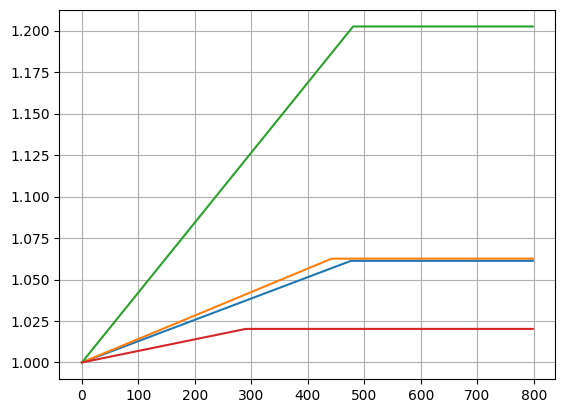

In [4]:
plt.plot(s[:, -4:])
plt.grid() 

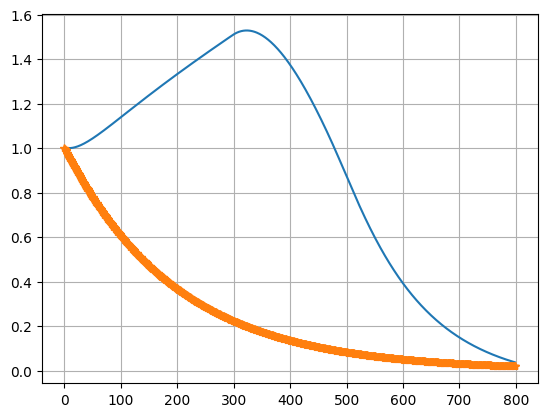

In [5]:
plt.plot(y[:, 3])
plt.grid() 

x = np.linspace(0, 800, 800)
ye = np.exp(-x/200)
plt.plot(ye, '--*')